In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import os
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.feature import local_binary_pattern
from copy import deepcopy
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import backend as K
from sklearn.model_selection import GridSearchCV

from keras.metrics import Accuracy

from tensorflow.keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from scipy.stats import t, entropy
from sklearn.manifold import _t_sne
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [7]:
def accuracy(label, labelhat):
    acc = sklearn.metrics.accuracy_score(label, labelhat) * 100

    #print(f"Accuracy : {acc}%")
    return acc

In [16]:
def DATASET():
    train_datagen = ImageDataGenerator(validation_split=0.15)
    test_datagen = ImageDataGenerator(validation_split=0.15)

    train_data = train_datagen.flow_from_directory(
        r'Indian Currency Dataset/train',
        color_mode="rgb",
        batch_size=2,
        class_mode='categorical',
        target_size=(100, 100),
        shuffle=False, 
        seed=42)

    test_data = train_datagen.flow_from_directory(
        r'Indian Currency Dataset/test',
        color_mode="rgb",
        batch_size=2,
        class_mode='categorical',
        target_size=(100, 100),
        shuffle=False, 
        seed=42)

    train_x=np.concatenate([train_data.next()[0] for i in range(train_data.__len__())])
    train_y=np.concatenate([train_data.next()[1] for i in range(train_data.__len__())])

    test_x=np.concatenate([test_data.next()[0] for i in range(test_data.__len__())])
    test_y=np.concatenate([test_data.next()[1] for i in range(test_data.__len__())])

    train_y = np.argmax(train_y, axis = 1)
    test_y = np.argmax(test_y, axis = 1)

    return train_x, train_y, test_x, test_y

# LBP Feature

In [9]:
def NBest(data, label, Num):
    
    chi2selection = SelectKBest(chi2, k=Num)
    newdata = chi2selection.fit_transform(data, label)
    return newdata

In [10]:
def GABOR_Features(img):
    histograms = []
    for theta in range(0, 4):
        theta = deepcopy(theta/4. * np.pi)
        for sigma in (2, 4):
            for lambda_ in np.arange(np.pi / 4, np.pi, np.pi / 4.):
                for gamma in (0.05, 0.5):
                    kernel__ = cv.getGaborKernel((8, 8), sigma, theta, lambda_, gamma, 0, ktype=cv.CV_32F)
                    filtered = cv.filter2D(img, ddepth=4, kernel= kernel__)
                    hist = cv.calcHist([np.float32(filtered)],[0],None,[256],[0,256]).reshape(-1)
                    histograms.append(hist)
    return np.reshape(histograms, (-1))

In [11]:
def LBP_Features(img):
        lbp = local_binary_pattern(img, 16, 8)
        his = np.histogram(lbp.ravel(), bins=200)
        return np.reshape(his[0], (-1))

In [12]:
def LBP_Gabor_Features(data, method):
    featurematrix = []
    for i in range(len(data)):
        img = data[i]
        lbp = LBP_Features(img)
        gab = GABOR_Features(img)
        if method == 'both':
            features = np.append(lbp, gab, axis = 0)
        elif method == 'lbp':
            features = lbp
        elif method == 'gabor':
            features = gab
        featurematrix.append(features)
    return np.array(featurematrix)

In [13]:
def LowFeatures(data, method = 'both'):
    red_data = data[:, :, :, 0]
    green_data = data[:, :, :, 1]
    blue_data = data[:, :, :, 2]

    red_features = LBP_Gabor_Features(red_data, method)
    green_features = LBP_Gabor_Features(green_data, method)
    blue_features = LBP_Gabor_Features(blue_data, method)
    rgb_features = np.append(red_features, green_features, axis = 1)
    rgb_features = np.append(rgb_features, blue_features, axis = 1)
    return rgb_features

In [17]:
train_x, train_y, test_x, test_y = DATASET()

Found 248 images belonging to 2 classes.
Found 107 images belonging to 2 classes.


In [18]:
train_x_Low = LowFeatures(train_x, method='lbp')
test_x_Low = LowFeatures(test_x, method='lbp')

In [20]:
train_x_Low.shape

(248, 600)

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score

In [98]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

# SVM

In [28]:
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(train_x_Low, train_y) #For sklearn no one hot encoding

prediction = svm_model.predict(test_x_Low)

svm_acc = accuracy_score(test_y, prediction)
svm_prec = precision_score(test_y, prediction,average='weighted')
svm_rec = recall_score(test_y, prediction,average='weighted')
svm_f1 = f1_score(test_y, prediction,average='weighted')

In [99]:
storeResults('LBP-SVM',svm_acc,svm_prec,svm_rec,svm_f1)

# KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)

knn_model.fit(train_x_Low, train_y) #For sklearn no one hot encoding

prediction = knn_model.predict(test_x_Low)

knn_acc = accuracy_score(test_y, prediction)
knn_prec = precision_score(test_y, prediction,average='weighted')
knn_rec = recall_score(test_y, prediction,average='weighted')
knn_f1 = f1_score(test_y, prediction,average='weighted')

In [100]:
storeResults('LBP-KNN',knn_acc,knn_prec,knn_rec,knn_f1)

# Voting Classifier

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()

eclf1 = VotingClassifier(estimators=[('dt', clf1),('rf', clf2)], voting='soft')

eclf1.fit(train_x_Low, train_y) #For sklearn no one hot encoding

prediction = eclf1.predict(test_x_Low)

vot_acc = accuracy_score(test_y, prediction)
vot_prec = precision_score(test_y, prediction,average='weighted')
vot_rec = recall_score(test_y, prediction,average='weighted')
vot_f1 = f1_score(test_y, prediction,average='weighted')

In [101]:
storeResults('LBP-Voting',vot_acc,vot_prec,vot_rec,vot_f1)

# CNN

In [37]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [34]:
# Resizinig all the images to (224,224)
IMAGE_SIZE = [128,128]

train_path = 'Indian Currency Dataset/train'
test_path = 'Indian Currency Dataset/test'

In [35]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [36]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(128,128),
                                              batch_size=2,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(128,128),
                                            batch_size=2,
                                            class_mode='categorical')

Found 248 images belonging to 2 classes.
Found 107 images belonging to 2 classes.


In [42]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [43]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = (128, 128, 3)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

learning_rate = 0.001

model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate),
              metrics=['accuracy',f1_m,precision_m, recall_m])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_8 (Batch (None, 126, 126, 16)      64        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 124, 124, 16)      2320      
_________________________________________________________________
batch_normalization_9 (Batch (None, 124, 124, 16)      64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 60, 60, 32)       

In [44]:
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

In [45]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

In [46]:
history = model.fit(
    train_set,
    epochs=10,
    validation_data=test_set,
    callbacks=[learning_rate_reduction, early_stop],
)

Epoch 1/10
124/124 [==============================] - 11s 53ms/step - loss: 16.0627 - accuracy: 0.6169 - f1_m: 0.6169 - precision_m: 0.6169 - recall_m: 0.6169 - val_loss: 9.5087 - val_accuracy: 0.4486 - val_f1_m: 0.4537 - val_precision_m: 0.4537 - val_recall_m: 0.4537
Epoch 2/10
124/124 [==============================] - 6s 50ms/step - loss: 10.0388 - accuracy: 0.6895 - f1_m: 0.6895 - precision_m: 0.6895 - recall_m: 0.6895 - val_loss: 8.4112 - val_accuracy: 0.4486 - val_f1_m: 0.4444 - val_precision_m: 0.4444 - val_recall_m: 0.4444
Epoch 3/10
124/124 [==============================] - 6s 50ms/step - loss: 5.8008 - accuracy: 0.7863 - f1_m: 0.7863 - precision_m: 0.7863 - recall_m: 0.7863 - val_loss: 34.7983 - val_accuracy: 0.4486 - val_f1_m: 0.4444 - val_precision_m: 0.4444 - val_recall_m: 0.4444
Epoch 4/10
124/124 [==============================] - 6s 49ms/step - loss: 5.2669 - accuracy: 0.7984 - f1_m: 0.7984 - precision_m: 0.7984 - recall_m: 0.7984 - val_loss: 7.6325 - val_accuracy: 0.7

In [102]:
dl_acc = history.history["val_accuracy"][9]
dl_prec =history.history["val_precision_m"][9] 
dl_rec = history.history["val_recall_m"][9] 
dl_f1 = history.history["val_f1_m"][9]

storeResults('CNN',dl_acc,dl_prec,dl_rec,dl_f1)

In [48]:
model.save('cnn.h5')

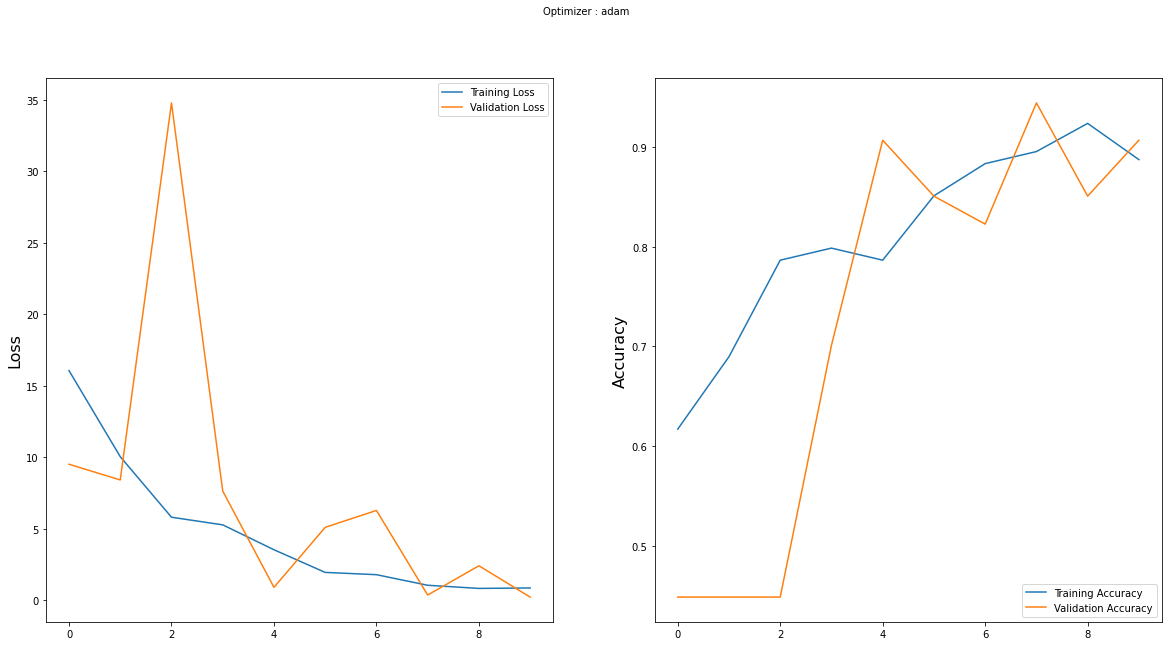

In [49]:
import matplotlib.pyplot as plt

x=history
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Xception

In [54]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

In [55]:
# Defining the pretrained base model
base = Xception(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(2, activation='softmax')(x)
# Combining base and head 
model1 = Model(inputs=base.input, outputs=head)

model1.compile(optimizer='sgd', 
              loss = 'categorical_crossentropy', 
              metrics=["accuracy",f1_m,precision_m, recall_m])

model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [57]:
history1 = model1.fit(
    train_set,
    epochs=10,
    validation_data=test_set,
    #callbacks=[learning_rate_reduction, early_stop],
)

Epoch 1/10
54/54 [==============================] - 3s 54ms/step - loss: 0.1343 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.2482 - val_accuracy: 0.9439 - val_f1_m: 0.9444 - val_precision_m: 0.9444 - val_recall_m: 0.9444
Epoch 2/10
54/54 [==============================] - 3s 50ms/step - loss: 0.2192 - accuracy: 0.9439 - f1_m: 0.9444 - precision_m: 0.9444 - recall_m: 0.9444 - val_loss: 0.2222 - val_accuracy: 0.9439 - val_f1_m: 0.9444 - val_precision_m: 0.9444 - val_recall_m: 0.9444
Epoch 3/10
54/54 [==============================] - 3s 48ms/step - loss: 0.2227 - accuracy: 0.9720 - f1_m: 0.9722 - precision_m: 0.9722 - recall_m: 0.9722 - val_loss: 1.0599 - val_accuracy: 0.8785 - val_f1_m: 0.8796 - val_precision_m: 0.8796 - val_recall_m: 0.8796
Epoch 4/10
54/54 [==============================] - 3s 48ms/step - loss: 0.2358 - accuracy: 0.9252 - f1_m: 0.9259 - precision_m: 0.9259 - recall_m: 0.9259 - val_loss: 0.2031 - val_accuracy: 0.9907 - val_f1

In [103]:
dl_acc = history1.history["val_accuracy"][9]
dl_prec =history1.history["val_precision_m"][9] 
dl_rec = history1.history["val_recall_m"][9] 
dl_f1 = history1.history["val_f1_m"][9]

storeResults('Xception',dl_acc,dl_prec,dl_rec,dl_f1)

In [58]:
model1.save('xception.h5')

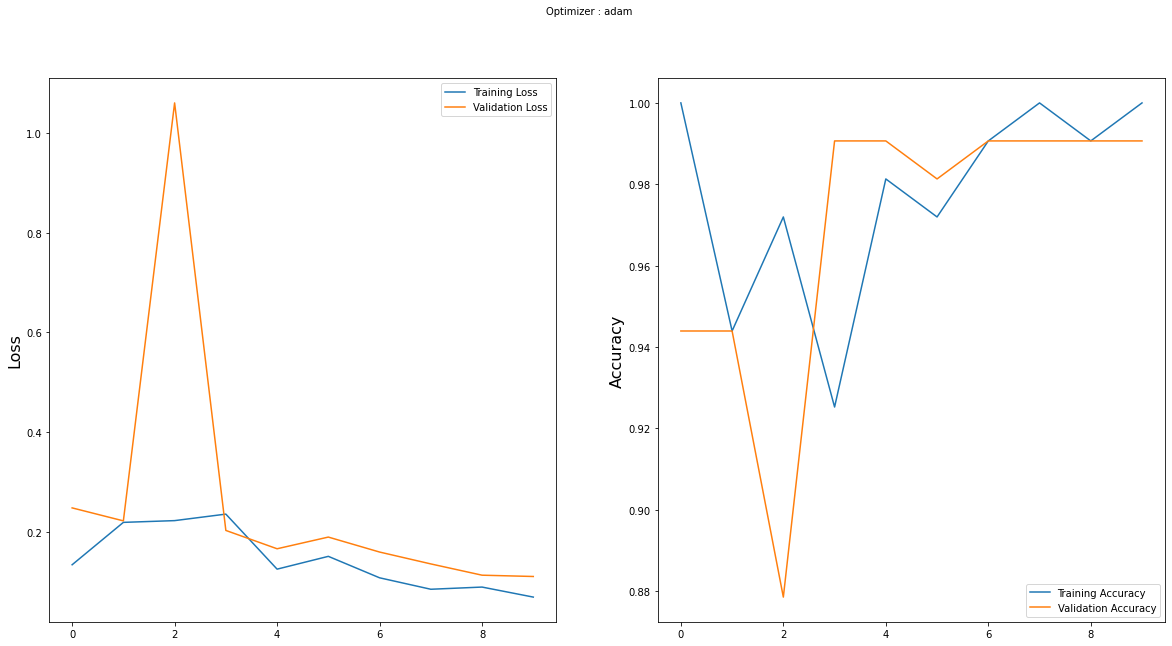

In [59]:
import matplotlib.pyplot as plt

x=history1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

FE

In [60]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns

In [61]:
# Read input images and assign labels based on folder names
print(os.listdir("Indian Currency Dataset/"))

SIZE = 128  #Resize images

#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

['test', 'train']


In [63]:
for directory_path in glob.glob("Indian Currency Dataset/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

fake
Indian Currency Dataset/train\fake\1 (1) - Copy.jpg
Indian Currency Dataset/train\fake\1 (1).jpg
Indian Currency Dataset/train\fake\1 (10).jpg
Indian Currency Dataset/train\fake\1 (100).jpg
Indian Currency Dataset/train\fake\1 (101).jpg
Indian Currency Dataset/train\fake\1 (102).jpg
Indian Currency Dataset/train\fake\1 (103).jpg
Indian Currency Dataset/train\fake\1 (104).jpg
Indian Currency Dataset/train\fake\1 (105).jpg
Indian Currency Dataset/train\fake\1 (106).jpg
Indian Currency Dataset/train\fake\1 (107).jpg
Indian Currency Dataset/train\fake\1 (108).jpg
Indian Currency Dataset/train\fake\1 (109).jpg
Indian Currency Dataset/train\fake\1 (11).jpg
Indian Currency Dataset/train\fake\1 (110).jpg
Indian Currency Dataset/train\fake\1 (111).jpg
Indian Currency Dataset/train\fake\1 (112).jpg
Indian Currency Dataset/train\fake\1 (12).jpg
Indian Currency Dataset/train\fake\1 (13).jpg
Indian Currency Dataset/train\fake\1 (14).jpg
Indian Currency Dataset/train\fake\1 (15).jpg
Indian Curr

In [64]:
#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [76]:
# Capture test/validation data and labels into respective lists

test_images = []
test_labels = [] 
for directory_path in glob.glob("Indian Currency Dataset/test/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

In [77]:
#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [79]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [80]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

###################################################################
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0


In [81]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# CNN

In [82]:
from keras.models import load_model

model_path1 = 'cnn.h5' # load .h5 Model

model = load_model(model_path1, custom_objects={'f1_score' : f1_m, 'precision_score' : precision_m, 'recall_score' : recall_m}, compile=False)

In [83]:
#Now, let us use features from convolutional network for RF
feature_extractor= model.predict(x_train)

In [84]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_train_feature = features

In [85]:
X_test_feature = model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

# SVM

In [86]:
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction = svm_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction = le.inverse_transform(prediction)

svm1_acc = accuracy_score(test_labels, prediction)
svm1_prec = precision_score(test_labels, prediction,average='weighted')
svm1_rec = recall_score(test_labels, prediction,average='weighted')
svm1_f1 = f1_score(test_labels, prediction,average='weighted')

In [104]:
storeResults('CNN-SVM',svm1_acc,svm1_prec,svm1_rec,svm1_f1)

# KNN

In [88]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction = knn_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction = le.inverse_transform(prediction)

knn1_acc = accuracy_score(test_labels, prediction)
knn1_prec = precision_score(test_labels, prediction,average='weighted')
knn1_rec = recall_score(test_labels, prediction,average='weighted')
knn1_f1 = f1_score(test_labels, prediction,average='weighted')

In [105]:
storeResults('CNN-KNN',knn1_acc,knn1_prec,knn1_rec,knn1_f1)

# Voting Classifier

In [89]:
eclf1 = VotingClassifier(estimators=[('dt', clf1),('rf', clf2)], voting='soft')

eclf1.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction = eclf1.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction = le.inverse_transform(prediction)

vot1_acc = accuracy_score(test_labels, prediction)
vot1_prec = precision_score(test_labels, prediction,average='weighted')
vot1_rec = recall_score(test_labels, prediction,average='weighted')
vot1_f1 = f1_score(test_labels, prediction,average='weighted')

In [106]:
storeResults('CNN-Voting',vot1_acc,vot1_prec,vot1_rec,vot1_f1)

# Xception

In [90]:
model_path1 = 'xception.h5' # load .h5 Model

model = load_model(model_path1, custom_objects={'f1_score' : f1_m, 'precision_score' : precision_m, 'recall_score' : recall_m}, compile=False)

In [91]:
#Now, let us use features from convolutional network for RF
feature_extractor= model.predict(x_train)

In [92]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_train_feature = features

In [93]:
X_test_feature = model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

# SVM

In [94]:
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction = svm_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction = le.inverse_transform(prediction)

svm2_acc = accuracy_score(test_labels, prediction)
svm2_prec = precision_score(test_labels, prediction,average='weighted')
svm2_rec = recall_score(test_labels, prediction,average='weighted')
svm2_f1 = f1_score(test_labels, prediction,average='weighted')

In [107]:
storeResults('Xception-SVM',svm2_acc,svm2_prec,svm2_rec,svm2_f1)

# KNN

In [95]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction = knn_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction = le.inverse_transform(prediction)

knn2_acc = accuracy_score(test_labels, prediction)
knn2_prec = precision_score(test_labels, prediction,average='weighted')
knn2_rec = recall_score(test_labels, prediction,average='weighted')
knn2_f1 = f1_score(test_labels, prediction,average='weighted')

In [108]:
storeResults('Xception-KNN',knn2_acc,knn2_prec,knn2_rec,knn2_f1)

# Voting Classifier

In [96]:
eclf1 = VotingClassifier(estimators=[('dt', clf1),('rf', clf2)], voting='soft')

eclf1.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction = eclf1.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction = le.inverse_transform(prediction)

vot2_acc = accuracy_score(test_labels, prediction)
vot2_prec = precision_score(test_labels, prediction,average='weighted')
vot2_rec = recall_score(test_labels, prediction,average='weighted')
vot2_f1 = f1_score(test_labels, prediction,average='weighted')

In [109]:
storeResults('Xception-Voting',vot2_acc,vot2_prec,vot2_rec,vot2_f1)

# Comparison

In [110]:
#creating dataframe
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                        'Precision': precision,
                        'Recall'   : recall,
                        'F1-Score': f1score,
                        
                      })

In [111]:
result

,ML Model,Accuracy,Precision,Recall,F1-Score
0,LBP-SVM,0.729,0.750,0.729,0.728
1,LBP-KNN,0.953,0.958,0.953,0.953
2,LBP-Voting,1.000,1.000,1.000,1.000
3,CNN,0.907,0.907,0.907,0.907
4,Xception,0.991,0.991,0.991,0.991
5,CNN-SVM,0.950,0.955,0.950,0.950
6,CNN-KNN,0.970,0.972,0.970,0.970
7,CNN-Voting,1.000,1.000,1.000,1.000
8,Xception-SVM,0.980,0.981,0.980,0.980
9,Xception-KNN,0.980,0.981,0.980,0.980


# Modelling

In [112]:
import joblib
filename = 'model.sav'
joblib.dump(eclf1, filename)

['model.sav']

# Graph

In [113]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

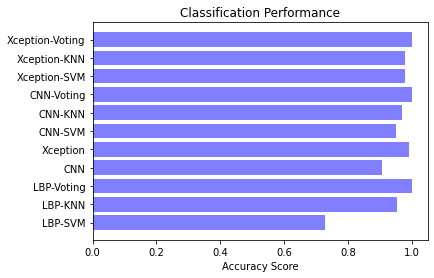

In [114]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

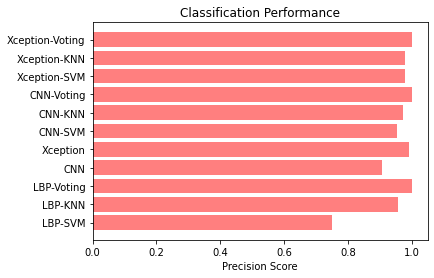

In [115]:
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

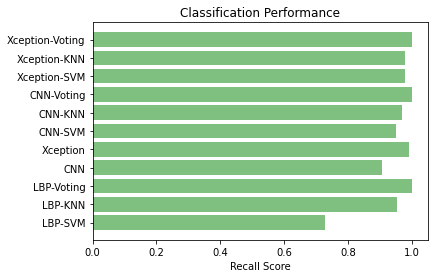

In [116]:
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='green')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1 Score

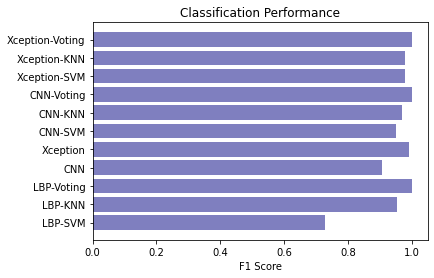

In [117]:
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='navy')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()